# Trabalho de casa 02: Regressão linear

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'.

## Exercícios computacionais

**Exercício 1.** Deixamos à sua disposição o dataset ["California Housing"](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing), dividido em treino, teste e validação.
O modelo que você utilizará para aproximar a relação funcional entre as features e as labels é o modelo linear, i.e., $\boldsymbol{y} = X\theta$.
Entretanto, você deve estimar seus parâmetros (minimizando o *mean squared error*) com **dois algoritmos diferentes**.
Uma implementação deve estimar $\theta$ por meio de **Stochastic Gradient Descent (SGD)** e, a outra, por meio de **Ordinary Least Squares (OLS)**, ou seja, utilizar a solução em fórmula fechada vista em aula.

Para o SGD, o ponto inicial deve ser escolhido aleatoriamente e o algoritmo deve parar quando a norma da diferença entre duas estimativas consecutivas de $\theta$ for menor do que um $\varepsilon > 0$ previamente especificado.
Para o experimento a seguir, fixe $\varepsilon$ em um valor pequeno (por exemplo, alguma potência de $1/10$) para a qual o algoritmo convirja no máximo em alguns minutos para uma solução com perda pequena.

Para diferentes tamanhos de minibatch (por exemplo $\{2^{j}: 1 \leq j \leq 7\}$), plote um gráfico representando o valor da perda $ L(\hat{\theta}) = \frac{1}{n} \lVert X \hat{\theta} - \mathbf{y} \rVert^{2}$ no conjunto de validação em função do número de epochs. Mostre também o valor ótimo obtido com OLS. Comente os resultados e o efeito tamanho do minibatch, e.g., no tempo de treinamento. Reporte valores nos conjuntos de treino, validação e teste.

In [21]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

features, labels = fetch_california_housing(return_X_y=True)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.25
)
features_train, features_validation, labels_train, labels_validation = train_test_split(
    features_train, labels_train, test_size=0.25
)

**Resposta**:

In [22]:
import os
# Define o número de threads como 1 para garantir determinismo e prevenir
# um memory leak na implementação do KMeans do scikit-learn
os.environ["OMP_NUM_THREADS"] = "1"

# Sets e Labels para criação de dataframes com os resultados
feature_sets = [features_train, features_validation, features_test]
label_sets = [
    labels.reshape(-1, 1) for labels in [
        labels_train, labels_validation, labels_test
    ]
]

In [23]:
# Error quadrático médio
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Gradiente Descendente Estocástico
def train_SGD(
    X: np.ndarray, y: np.ndarray, batch_size: int, tolerance: float = 1e-3,
    learning_rate: float = 1e-8, n_epochs: int = 2000
) -> tuple[np.ndarray, list[float]]:

    losses = []
    y = y.reshape(-1, 1)
    rng = np.random.default_rng(SEED)
    theta = rng.normal(size=(X.shape[1], 1), scale=0.01)
    learn_rate = np.array([learning_rate])

    # Para cada época t = 1,2,...,T
    for _ in tqdm(range(n_epochs), f'Ajustando modelo, {n_epochs} epochs', unit='epoch'):
        # Gera uma permutação aleatória dos índices
        indices = rng.permutation(X.shape[0])
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        for i in range(0, X.shape[0], batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            difference = X_batch @ theta - y_batch
            gradients = 2 * X_batch.T @ difference
            # Atualiza theta
            theta -= learn_rate * gradients / batch_size

        # Calcula a perda
        loss = mse(y, X.dot(theta))
        losses.append(loss)
        # Se a perda for menor que a tolerância, para
        if loss < tolerance:
            break

    return theta, losses

# Mínimos Quadrados Ordinários (OLS)
def train_OLS(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    theta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y.reshape(-1, 1)) # (X^T X)^-1 X^T y
    return theta

Ajustando modelo, 2000 epochs:   0%|          | 2/2000 [00:00<01:45, 18.95epoch/s]

Ajustando modelo, 2000 epochs: 100%|██████████| 2000/2000 [00:04<00:00, 458.59epoch/s]


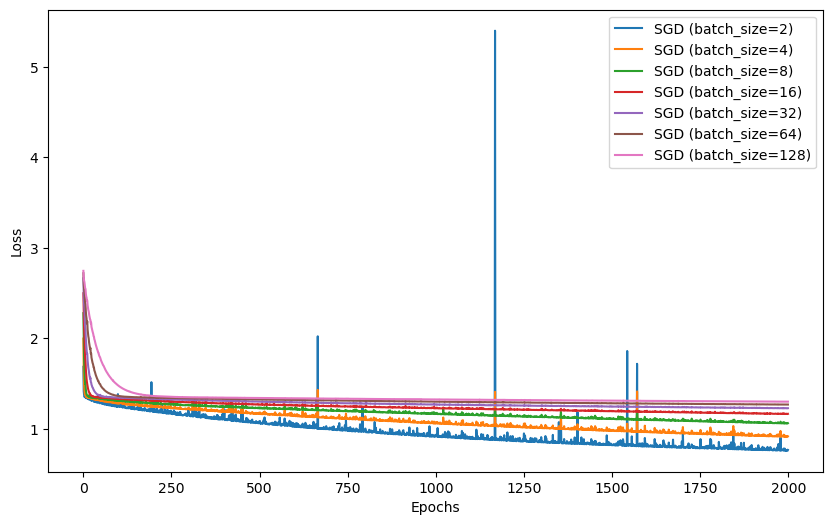

In [24]:
# Define o tamanho dos batches
batch_sizes = [2**j for j in range(1, 8)]
data = {'Train': [], 'Validation': [], 'Test': []}

theta_ols = train_OLS(features_train, labels_train)
for col, features, labels in zip(data.keys(), feature_sets, label_sets):
    data[col].append(mse(labels, features.dot(theta_ols)))

# Plotando os resultados
plt.figure(figsize=(10, 6))
for batch_size in batch_sizes:
    theta, losses_sgd = train_SGD(features_train, labels_train, batch_size=batch_size)
    for col, features, labels in zip(data.keys(), feature_sets, label_sets):
        data[col].append(mse(labels, features.dot(theta)))
    plt.plot(losses_sgd, label=f'SGD (batch_size={batch_size})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
index = ["OLS"] + [f"SGD (batch_size={batch_size})" for batch_size in batch_sizes]
results = pd.DataFrame(data, index=index)
results

,Train,Validation,Test
OLS,0.594349,0.629434,0.611985
SGD (batch_size=2),0.766697,0.775539,0.766021
SGD (batch_size=4),0.916867,0.932048,0.914920
SGD (batch_size=8),1.061677,1.083628,1.058456
SGD (batch_size=16),1.164766,1.191975,1.160999
SGD (batch_size=32),1.227514,1.256093,1.223256
SGD (batch_size=64),1.267989,1.292941,1.261242
SGD (batch_size=128),1.299942,1.318532,1.287652


O SGD foi menos eficiente que o OLS, pois as iterações são significativamente mais lentas que a solução em fórmula fechada e não há garantia de convergência. Além disso, em um problema simples e, possivelmente, linear, o OLS obtém melhores resultados.

Como a descida do gradiente é feita com base nos dados do batch, tamanhos menores podem não ser tão estáveis por não representar adequadamente a distribuição dos dados. Aumentar esse tamanho também acelera o treinamento, pois as operações vetorizadas podem ser realizadas em mais dados por vez.

Por outro lado, aumentar o tamanho do batch também leva a um número menor de descidas do gradiente, supondo um número fixo de épocas. Assim, pode-se esperar que o erro aumente em algum ponto, principalmente se um batch pequeno é suficiente, pois o algoritmo não terá atualizações suficientes para convergir. 

**Exercício 2.** Agora, utilizando ainda o mesmo dataset da questão anterior, você deve implementar uma **Rede RBF** com função de base Gaussiana (veja as notas de aula).
Para os centróides, utilize o output de um modelo de clusterização por K médias, por meio da função que disponibilizamos, como a seguir:



In [26]:
def k_means_factory(n_clusters: int) -> KMeans:
    return KMeans(n_clusters=n_clusters, n_init="auto", copy_x=False, random_state=SEED)

# Número de centróides/clusters
k_means_model = k_means_factory(n_clusters=2)
dumb_data = np.array([
    [1, 2],
    [1, 4],
    [1, 0],
    [10, 2],
    [10, 4],
    [10, 0]
])
k_means_model.fit(dumb_data)
cluster_centers = k_means_model.cluster_centers_
print(cluster_centers) # Shape (n_clusters, n_features)

[[ 1.  2.]
 [10.  2.]]


c:\Users\iaram\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Para determinar o melhor valor de $k$ para o algoritmo de clusterização, treine o modelo (usando a fórmula de OLS) com diferentes valores e escolha o que possuir o menor erro de validação. Faça um gráfico mostrando o valor do erro de validação para diferentes valores de $k$. Mostre também a performance do modelo escolhido no conjunto de teste. Compare com o modelo linear simples da questão anterior. Discuta os resultados.

Para definir o valor do hiper-parâmetro $\gamma$, use a seguinte heurística --- que pode ser achado no livro "Neural Networks", por Simon Haykin:

$$
\gamma = \frac{1}{d_\text{max}^2},
$$

onde $d_\text{max}$ é a maior distância entre um par de centróides. Note que o valor costuma mudar para $k$'s diferentes.

**Resposta**:

Começamos criando uma função para calcular a transformação RBF. Para isso, utilizamos a função de base Gaussiana:

$$f_{c_i} = \exp \left( -\gamma \lVert x - c_i \rVert_2 ^2 \right)$$

Onde $c_i$ é o centróide, $x$ é a entrada e $\gamma$ é uma constante, que é o inverso do quadrado da maior distância entre os centróides.

In [27]:
# Aplicação da transformação RBF
def rbf_transformation(features: np.ndarray, centers: np.ndarray, gamma: float) -> np.ndarray:
    return np.exp(-gamma * np.linalg.norm(features[:, np.newaxis] - centers, axis=2)**2)

def calculate_gamma(cluster_centers: np.ndarray) -> float:
    # Cria uma matriz kxkxfeatures com os centroides repetidos
    c = np.expand_dims(cluster_centers, axis=0)
    c_matrix = np.repeat(c, c.shape[1], axis=0)
    # Calcula a matriz de distâncias
    dist_matrix = c_matrix - np.expand_dims(c, axis=2)
    dist_matrix = np.linalg.norm(dist_matrix, axis=2)
    # Calcular gamma usando a maior distância entre os centróides
    d_max = np.max(dist_matrix)
    gamma = 1 / (d_max ** 2)
    return gamma

Agora, para encontrar o melhor valor de $k$, criamos um loop que treina o modelo para diferentes valores de $k$ e calcula o erro de validação. Para cada valor, transformamos as features e treinamos o modelo com OLS. Com o $\theta$ encontrado, calculamos o MSE no conjunto de validação e guardamos o valor.

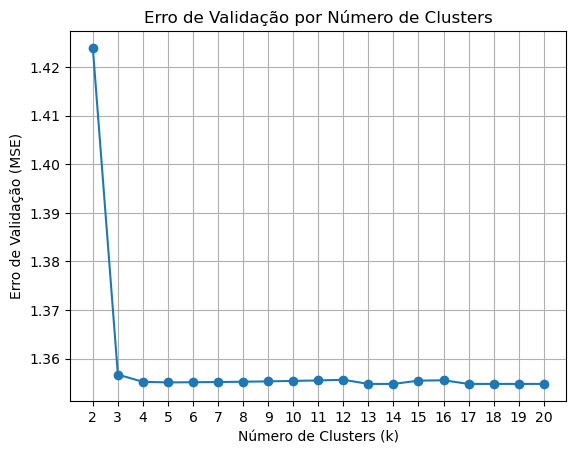

In [28]:
# Variável para armazenar os resultados
validation_errors = []
gammas = []
data = {'Train': [], 'Validation': [], 'Test': []}

ks = range(2, 21)  # Testar valores de k de 2 a 20

for k in ks:
    # Treinar o K-Means
    k_means_model = k_means_factory(n_clusters=k).fit(features_train)
    cluster_centers = k_means_model.cluster_centers_
    gamma = calculate_gamma(cluster_centers)
    gammas.append(gamma)

    # Transformar as features
    features_train_rbf = rbf_transformation(features_train, cluster_centers, gamma)
    features_validation_rbf = rbf_transformation(features_validation, cluster_centers, gamma)
    features_test_rbf = rbf_transformation(features_test, cluster_centers, gamma)

    # Treinar o regressor OLS
    theta = train_OLS(features_train_rbf, labels_train)
    mse_value = mse(labels_validation, features_validation_rbf @ theta)

    # Armazenar os resultados
    features_sets = [features_train_rbf, features_validation_rbf, features_test_rbf]
    for col, features, labels in zip(data.keys(), features_sets, label_sets):
        #print(labels.shape, features.shape, theta.shape)
        data[col].append(mse(labels, features.dot(theta)))

    # Avaliar no conjunto de validação
    validation_errors.append(mse_value)

# Plotar os erros de validação
plt.plot(ks, validation_errors, marker='o')
plt.title('Erro de Validação por Número de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Erro de Validação (MSE)')
plt.xticks(ks)
plt.grid(True)
plt.show()

Podemos encontrar os erros de treino, validação e teste para diferentes valores de $k$: 

In [29]:
data = pd.DataFrame(data, index=ks)
data

,Train,Validation,Test
2,1.394413,1.444596,1.396335
3,1.328219,1.353312,1.323302
4,1.326315,1.352083,1.321740
5,1.326427,1.351685,1.321848
6,1.326364,1.351367,1.321646
7,1.326325,1.351197,1.321573
8,1.326238,1.351019,1.321441
9,1.326161,1.350863,1.321320
10,1.326055,1.350684,1.321147
11,1.325934,1.350482,1.320971


Diferente do SDG, a RBF é capaz de capturar relações não-lineares, entretanto, no dataset "California Housing" o modelo linear já é capaz de capturar a relação entre as features e as labels, o que faz com que a RBF não tenha uma performancemelhor. Também podemos ver que o valor de $\gamma$ diminui com o aumento de $k$, pois a distância entre os centróides diminui. Isso faz com que a função de base Gaussiana se torne mais "pontual", o que pode ser útil para capturar padrões mais específicos.

In [30]:
for i in range(len(gammas)):
    print(f"Para k={ks[i]}, gamma={gammas[i]}")

Para k=2, gamma=1.4074060285520246e-07
Para k=3, gamma=2.3189196263876544e-08
Para k=4, gamma=3.696577532261886e-09
Para k=5, gamma=2.102943152926845e-09
Para k=6, gamma=2.3532383887005703e-10
Para k=7, gamma=2.050581703171583e-10
Para k=8, gamma=1.7690560992059658e-10
Para k=9, gamma=1.5292302604152615e-10
Para k=10, gamma=1.352313637483433e-10
Para k=11, gamma=1.1980185356607027e-10
Para k=12, gamma=1.0843806354114697e-10
Para k=13, gamma=9.953453678662914e-11
Para k=14, gamma=9.346708524585001e-11
Para k=15, gamma=7.379878821519661e-11
Para k=16, gamma=6.781016795103542e-11
Para k=17, gamma=6.465404978872603e-11
Para k=18, gamma=6.261554223796495e-11
Para k=19, gamma=5.868654541851983e-11
Para k=20, gamma=5.490482301270418e-11


Testando para $k = 2, \ldots, 20$, encontramos que o menor erro de validação foi obtido para $k = 12$ em todos os conjuntos de treino, validação e teste.

In [31]:
for errors in data.columns:
    print(f"Melhor erro para {errors}: {min(data[errors])} com k={data[errors].idxmin()}")

Melhor erro para Train: 1.3257776290213672 com k=12
Melhor erro para Validation: 1.3502299632210601 com k=12
Melhor erro para Test: 1.3207477514219448 com k=12


# Exercícios de "papel e caneta"

**Exercício 1.** Deixe que $X \in \mathbb{R}^{N\times D}$, $c>0$ e $I$ denote a matriz identidade de dimensão $N$.
 Mostre que $X^\intercal X + c I$ possui inversa.

**Resposta**: Sabemos que a matriz $X^T X$ é sempre positiva semi-definida, pois para qualquer vetor $v$ temos que $v^T (X^T X) v = (Xv)^T Xv = \lVert Xv \rVert^2 \geq 0$. Ao adicionar $cI$, estamos somando uma matriz diagonal com $c$ em todas as entradas, onde $c > 0$. Então, analogamente, seja $A = X^T X + cI$. Para qualquer vetor não-nulo $v$, temos:
$$v^T A v = v^T (X^T X + cI) v =$$
$$v^T (X^T X) v + c v^T I v = \underbrace{\lVert Xv \rVert^2}_{\geq 0} + \underbrace{c \lVert v \rVert^2}_{>0} > 0$$

Com isso, podemos concluir que $X^T X + cI$ é positiva-definida, e portanto, é invertível.

**Exercício 2.** Deixe que $X \in \mathbb{R}^{N\times D}$ seja uma matriz contendo os exemplos de treinamento (um por linha) e que $y\in \mathbb{R}^N$ seja um vetor coluna dos outputs observados para cada vetor de input em suas linhas. Na aula, derivamos a solução de mínimos quadrados ordinários (OLS). Use o mesmo raciocínio para resolver achar o vetor de pesos ${\theta}$ que minimiza:
 
$$ \|X \theta - y\|_2^2 + c \|\theta\|_2^2,$$

onde $c>0$ é uma constante.

**Resposta**: Seja $J(\theta) = \|X \theta - y\|_2^2 + c \|\theta\|_2^2$. Para encontrar o mínimo de $J(\theta)$, devemos encontrar o ponto onde a derivada de $J(\theta)$ é zero. Então, temos:

$$J(\theta) = (X\theta - y)^T (X\theta - y) + c \theta^T \theta$$

Agora derivamos $J(\theta)$ em relação a $\theta$:

$$\frac{\partial J(\theta)}{\partial \theta} = \frac{\partial}{\partial \theta} \left[ (X\theta - y)^T (X\theta - y) + c \theta^T \theta \right] $$
$$= \frac{\partial}{\partial \theta} \left[ \theta^T X^T X \theta - \underbrace{\theta^T X^T y}_{= \; y^T X \theta} - y^T X \theta + y^T y + c \theta^T \theta \right]$$
$$= \frac{\partial}{\partial \theta} \left[ \theta^T X^T X \theta - 2y^T X \theta + y^T y + c \theta^T \theta \right]$$
$$= 2X^T X \theta - 2X^T y + 2c \theta$$

Igualando a derivada a zero, temos:

$$2X^T X \theta - 2X^T y + 2c \theta = 0$$
$$X^T X \theta + c \theta = X^T y$$
$$(X^T X + cI) \theta = X^T y$$
$$\theta = (X^T X + cI)^{-1} X^T y$$

Ao isolar $\theta$, encontramos a solução para o problema de minimização, onde $\theta$ é o vetor de pesos que minimiza a função de custo $J(\theta)$, com $c > 0$.

**Exercício 3.** Em algumas situações, temos muito mais features que amostras ($D \gg N$). Esse tipo de cenário é comum, e.g., na análise de dados genômicos. Nesse caso, costumam existir infinitas combinações lineares das features que expressam o vetor de saídas $y$. Portanto, precisamos de algum critério para escolher um deles. Uma abordagem possível, é escolher o vetor de pesos $\theta$ que possua menor norma L2.
Com isso em mente, derive a solução que minimiza $\|\theta\|_2^2$ e respeita $X \theta = y$. Assuma que as linhas de $X$ são linearmente independentes.

**Resposta:** Vamos utilizar o método dos multiplicadores de Lagrange para resolver esse problema.
$$J(\theta) = \|\theta\|_2^2 - \lambda^T (X\theta - y)$$
$$J(\theta) = \theta^T \theta - \lambda (X\theta - y)$$

onde $\lambda$ é o multiplicador de Lagrange. Agora, derivamos $J(\theta)$ em relação a $\theta$ e igualamos a zero:

$$\frac{\partial J(\theta)}{\partial \theta} = 2\theta - X^T \lambda = 0$$

Isolando $\theta$, temos:

$$\theta = \frac{1}{2} X^T \lambda \quad (1)$$

Substituindo $\theta$ na restrição $X\theta = y$, temos:

$$X\left(\frac{1}{2} X^T \lambda\right) = y$$

$$X X^T \lambda = 2y$$

$$\lambda = 2(X X^T)^{-1} y \quad (2)$$

Substituindo $(2)$ em $(1)$, temos:

$$\theta = X^T (X X^T)^{-1} y$$

Essa expressão é equivalente à solução dada pela pseudoinversa de Moore-Penrose de $X$, denotada como $X^{+}$, que é a generalização da inversa de uma matriz para o caso de matrizes não quadradas ou singulares.

No caso específico em que $N<D$ e as linhas de $X$ são linearmente independentes, a pseudoinversa de $X$ é dada por: $X^{+}=X^{\top}\left(X X^{\top}\right)^{-1}$. Esta formulação da pseudoinversa é específica para o caso em que temos mais colunas (features) que linhas (amostras) e garante que as linhas de $X$ sejam tratadas de forma que a solução resultante para $\theta$ seja a de menor norma L2 possível.

Substituindo $X^{+}$ na condição $X \theta=y$, também obteríamos: $\hat{\theta}_{\mathrm{MN}}=X^{+} y=X^{\top}\left(X X^{\top}\right)^{-1} y$